In [1]:
#!pip install aequitas==0.42.0 --quiet


## Importing Packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aequitas.group import Group
from aequitas.bias import Bias
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from IPython.display import display

## Loading Data and Exploration

In [2]:
# Load data
df_preds = pd.read_csv("image_metadata.csv")
df_val = pd.read_csv("fairface_label_train.csv")

# Rename columns for consistency
df_preds.rename(columns={'file_path': 'file'}, inplace=True)

In [3]:
# Merge the validation and predictions data
df_merged = pd.merge(df_val, df_preds, on='file', how='inner')

#filter by service_test = True for balaenced data
df_merged = df_merged[df_merged['service_test'] == True].reset_index(drop=True)

print(df_merged.columns.tolist())

['file', 'age', 'gender', 'race', 'service_test', 'confidence']


In [4]:
# Desired category orders
gender_order = ["Male", "Female"]
race_order = ["White", "Latino_Hispanic", "Indian", "East Asian", "Black", "Southeast Asian", "Middle Eastern"]
age_order = ["0-2", "3-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "more than 70"]

# Apply ordered categorical types to merged DataFrame
df_merged['age'] = pd.Categorical(df_merged['age'], categories=age_order, ordered=True)
df_merged['race'] = pd.Categorical(df_merged['race'], categories=race_order, ordered=True)
df_merged['gender'] = pd.Categorical(df_merged['gender'], categories=gender_order, ordered=True)

In [5]:
df_merged.head()

,file,age,gender,race,service_test,confidence
0,train/1.jpg,50-59,Male,East Asian,True,0.981539
1,train/4.jpg,20-29,Female,Indian,True,0.996233
2,train/5.jpg,20-29,Female,Indian,True,0.999085
3,train/6.jpg,20-29,Male,White,True,0.974714
4,train/8.jpg,30-39,Female,Indian,True,0.950043


In [6]:
# Count occurrences of each category in the original merged dataset
total_gender_counts = df_merged['gender'].value_counts()
total_race_counts = df_merged['race'].value_counts()
total_age_counts = df_merged['age'].value_counts()

# Print the results
print("Total Gender Distribution:")
print(total_gender_counts)
print("\nTotal Race Distribution:")
print(total_race_counts)
print("\nTotal Age Distribution:")
print(total_age_counts)

Total Gender Distribution:
gender
Male      20190
Female    20062
Name: count, dtype: int64

Total Race Distribution:
race
White              5777
East Asian         5772
Latino_Hispanic    5756
Indian             5754
Black              5754
Southeast Asian    5725
Middle Eastern     5714
Name: count, dtype: int64

Total Age Distribution:
age
20-29           15016
30-39            8398
10-19            4777
40-49            4536
3-9              3687
50-59            2133
60-69            1004
0-2               378
more than 70      323
Name: count, dtype: int64


## Threshold Setting for 95%, 90%, and 80% Confidence Predictions

In [7]:
# Coping the original DataFrame to a new one for 95% confidence threshold analysis
df_95_threshold_bal = df_merged.copy()

# Appling the 95% confidence threshold to create a binary 'score' for Aequitas
df_95_threshold_bal['score'] = df_95_threshold_bal['confidence'].apply(lambda x: 1 if x >= 0.95 else 0)

# For Aequitas analysis, a 'label_value'column is needed for absolute truth
df_95_threshold_bal['label_value'] = 1  # This assumes all entries should be faces

print(df_95_threshold_bal[['file', 'confidence','score', 'label_value']].head())
print("Distribution of 'detected' status:")
print(df_95_threshold_bal['score'].value_counts())

          file  confidence  score  label_value
0  train/1.jpg    0.981539      1            1
1  train/4.jpg    0.996233      1            1
2  train/5.jpg    0.999085      1            1
3  train/6.jpg    0.974714      1            1
4  train/8.jpg    0.950043      1            1
Distribution of 'detected' status:
score
1    36974
0     3278
Name: count, dtype: int64


In [8]:
# Coping the original DataFrame to a new one for 90% confidence threshold analysis
df_90_threshold_bal = df_merged.copy()

# Appling the 90% confidence threshold to create a binary 'score' for Aequitas
df_90_threshold_bal['score'] = df_90_threshold_bal['confidence'].apply(lambda x: 1 if x >= 0.90 else 0)


# For Aequitas analysis, a 'label_value'column is needed for absolute truth
df_90_threshold_bal['label_value'] = 1  # This assumes all entries should be faces

print(df_90_threshold_bal[['file', 'confidence', 'score', 'label_value']].head())
print("Distribution of 'detected' status:")
print(df_90_threshold_bal['score'].value_counts())

          file  confidence  score  label_value
0  train/1.jpg    0.981539      1            1
1  train/4.jpg    0.996233      1            1
2  train/5.jpg    0.999085      1            1
3  train/6.jpg    0.974714      1            1
4  train/8.jpg    0.950043      1            1
Distribution of 'detected' status:
score
1    38745
0     1507
Name: count, dtype: int64


In [9]:
# Coping the original DataFrame to a new one for 80% confidence threshold analysis

df_80_threshold_bal = df_merged.copy()

# Appling the 80% confidence threshold to create a binary 'score' for Aequitas
df_80_threshold_bal['score'] = df_80_threshold_bal['confidence'].apply(lambda x: 1 if x >= 0.80 else 0)

# For Aequitas analysis, a 'label_value'column is needed for absolute truth
df_80_threshold_bal['label_value'] = 1  # This assumes all entries should be faces

print(df_80_threshold_bal[['file', 'confidence', 'score', 'label_value']].head())
print("Distribution of 'detected' status:")
print(df_80_threshold_bal['score'].value_counts())

          file  confidence  score  label_value
0  train/1.jpg    0.981539      1            1
1  train/4.jpg    0.996233      1            1
2  train/5.jpg    0.999085      1            1
3  train/6.jpg    0.974714      1            1
4  train/8.jpg    0.950043      1            1
Distribution of 'detected' status:
score
1    39640
0      612
Name: count, dtype: int64


## 95% Confidence Threshold Exploration

In [10]:
#### Quick analysis For 95% threshold
print("\nScore Analysis by Group:")
for group in ['gender', 'race', 'age']:
    print(f"\nGroup: {group}")
    print(df_95_threshold_bal.groupby(group)['score'].agg(['mean', 'count', 'std']))
    
print("\nLabel Value Analysis by Group:")
for group in ['gender', 'race', 'age']:
    print(f"\nGroup: {group}")
    print(df_95_threshold_bal.groupby(group)['label_value'].agg(['mean', 'count', 'std']))

print("\nScore Value Counts by Gender, Race, and Age:")
print(df_95_threshold_bal.groupby(['gender', 'race', 'age'])
      ['score'].value_counts(normalize=True))


Score Analysis by Group:

Group: gender
            mean  count       std
gender                           
Male    0.906835  20190  0.290671
Female  0.930366  20062  0.254536

Group: race
                     mean  count       std
race                                      
White            0.902371   5777  0.296837
Latino_Hispanic  0.930507   5756  0.254312
Indian           0.931352   5754  0.252876
East Asian       0.915974   5772  0.277451
Black            0.891901   5754  0.310532
Southeast Asian  0.933450   5725  0.249263
Middle Eastern   0.924571   5714  0.264105

Group: age
                  mean  count       std
age                                    
0-2           0.944444    378  0.229365
3-9           0.946027   3687  0.225996
10-19         0.931128   4777  0.253262
20-29         0.921617  15016  0.268782
30-39         0.909264   8398  0.287250
40-49         0.901235   4536  0.298380
50-59         0.903422   2133  0.295451
60-69         0.896414   1004  0.304874
more than 7

In [11]:
# Filter for undetected faces 95% threshold
undetected_df_95_bal = df_95_threshold_bal[df_95_threshold_bal['score'] == 0]

# Count occurrences of each category within undetected faces
undetected_gender_counts_95_bal = undetected_df_95_bal['gender'].value_counts()
undetected_race_counts_95_bal = undetected_df_95_bal['race'].value_counts()
undetected_age_counts_95_bal = undetected_df_95_bal['age'].value_counts()

# Print the results
print("Undetected Gender Distribution:")
print(undetected_gender_counts_95_bal)
print("\nUndetected Race Distribution:")
print(undetected_race_counts_95_bal)
print("\nUndetected Age Distribution:")
print(undetected_age_counts_95_bal)

Undetected Gender Distribution:
gender
Male      1881
Female    1397
Name: count, dtype: int64

Undetected Race Distribution:
race
Black              622
White              564
East Asian         485
Middle Eastern     431
Latino_Hispanic    400
Indian             395
Southeast Asian    381
Name: count, dtype: int64

Undetected Age Distribution:
age
20-29           1177
30-39            762
40-49            448
10-19            329
50-59            206
3-9              199
60-69            104
more than 70      32
0-2               21
Name: count, dtype: int64


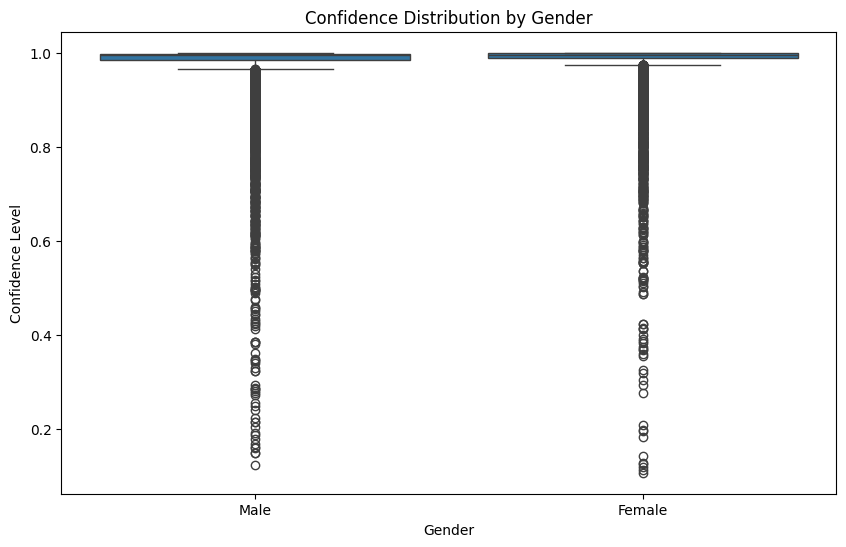

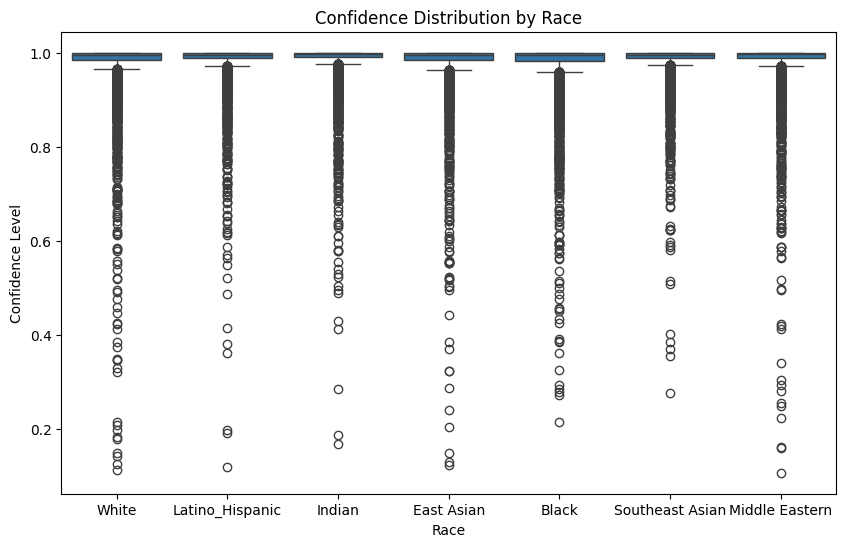

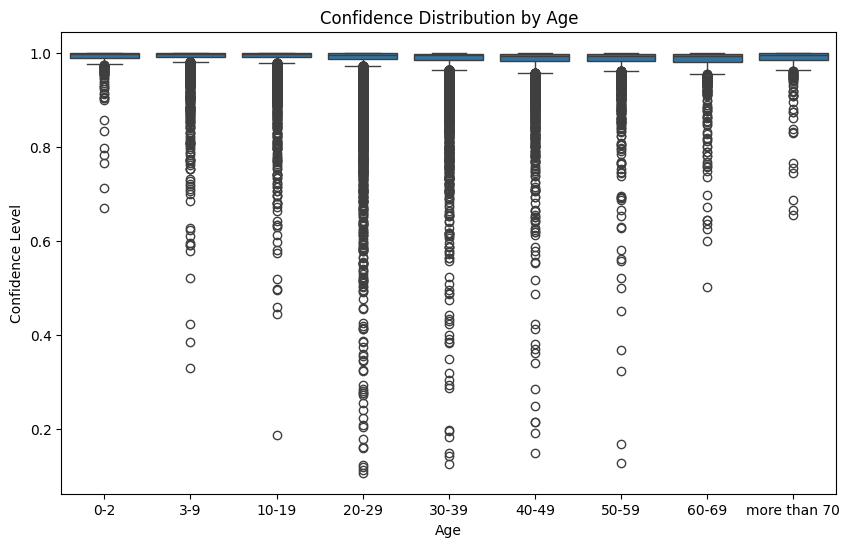

In [12]:
# Boxplt for predictions csv

for group in ['gender', 'race', 'age']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=group, y='confidence', data=df_merged)
    plt.title(f'Confidence Distribution by {group.capitalize()}')
    plt.xlabel(group.capitalize())
    plt.ylabel('Confidence Level')
    plt.show()

## 90% Confidence Threshold Exploration

In [13]:
# Quick analysis For 90% threshold

print("\nScore Analysis by Group:")
for group in ['gender', 'race', 'age']:
    print(f"\nGroup: {group}")
    print(df_90_threshold_bal.groupby(group)['score'].agg(['mean', 'count', 'std']))
    
print("\nLabel Value Analysis by Group:")
for group in ['gender', 'race', 'age']:
    print(f"\nGroup: {group}")
    print(df_90_threshold_bal.groupby(group)['label_value'].agg(['mean', 'count', 'std']))

print("\nScore Value Counts by Gender, Race, and Age:")
print(df_90_threshold_bal.groupby(['gender', 'race', 'age'])
      ['score'].value_counts(normalize=True))


Score Analysis by Group:

Group: gender
            mean  count       std
gender                           
Male    0.956662  20190  0.203623
Female  0.968498  20062  0.174675

Group: race
                     mean  count       std
race                                      
White            0.954475   5777  0.208471
Latino_Hispanic  0.969597   5756  0.171709
Indian           0.968370   5754  0.175029
East Asian       0.964657   5772  0.184661
Black            0.946820   5754  0.224413
Southeast Asian  0.973100   5725  0.161804
Middle Eastern   0.960973   5714  0.193676

Group: age
                  mean  count       std
age                                    
0-2           0.978836    378  0.144122
3-9           0.975047   3687  0.156002
10-19         0.969856   4777  0.171003
20-29         0.962107  15016  0.190944
30-39         0.959633   8398  0.196830
40-49         0.952160   4536  0.213450
50-59         0.961088   2133  0.193431
60-69         0.959163   1004  0.198010
more than 7

In [14]:
# Filter for undetected faces 90% threshold
undetected_df_90_bal = df_90_threshold_bal[df_90_threshold_bal['score'] == 0]

# Count occurrences of each category within undetected faces
undetected_gender_counts_90_bal = undetected_df_90_bal['gender'].value_counts()
undetected_race_counts_90_bal = undetected_df_90_bal['race'].value_counts()
undetected_age_counts_90_bal = undetected_df_90_bal['age'].value_counts()

# Print the results
print("Undetected Gender Distribution:")
print(undetected_gender_counts_90_bal)
print("\nUndetected Race Distribution:")
print(undetected_race_counts_90_bal)
print("\nUndetected Age Distribution:")
print(undetected_age_counts_90_bal)

Undetected Gender Distribution:
gender
Male      875
Female    632
Name: count, dtype: int64

Undetected Race Distribution:
race
Black              306
White              263
Middle Eastern     223
East Asian         204
Indian             182
Latino_Hispanic    175
Southeast Asian    154
Name: count, dtype: int64

Undetected Age Distribution:
age
20-29           569
30-39           339
40-49           217
10-19           144
3-9              92
50-59            83
60-69            41
more than 70     14
0-2               8
Name: count, dtype: int64


## 80% Confidence Threshold Exploration

In [15]:
# Quick analysis For 80% threshold

for group in ['gender', 'race', 'age']:
    print(df_80_threshold_bal.groupby(group)['score'].agg(['mean', 'count', 'std']))
    
for group in ['gender', 'race', 'age']:
    print(df_80_threshold_bal.groupby(group)['label_value'].agg(['mean', 'count', 'std']))

print(df_80_threshold_bal.groupby(['gender', 'race', 'age'])['score'].value_counts(normalize=True))

            mean  count       std
gender                           
Male    0.982566  20190  0.130886
Female  0.987040  20062  0.113104
                     mean  count       std
race                                      
White            0.981132   5777  0.136070
Latino_Hispanic  0.988707   5756  0.105674
Indian           0.986792   5754  0.114175
East Asian       0.984581   5772  0.123224
Black            0.977581   5754  0.148055
Southeast Asian  0.990044   5725  0.099292
Middle Eastern   0.984774   5714  0.122460
                  mean  count       std
age                                    
0-2           0.986772    378  0.114399
3-9           0.990778   3687  0.095598
10-19         0.988277   4777  0.107647
20-29         0.984417  15016  0.123861
30-39         0.981781   8398  0.133749
40-49         0.983686   4536  0.126694
50-59         0.985466   2133  0.119704
60-69         0.981076   1004  0.136326
more than 70  0.981424    323  0.135231
        mean  count  std
gender      

In [16]:
# Filter for undetected faces 80% threshold
undetected_df_80_bal = df_80_threshold_bal[df_80_threshold_bal['score'] == 0]

# Count occurrences of each category within undetected faces
undetected_gender_counts_80_bal = undetected_df_80_bal['gender'].value_counts()
undetected_race_counts_80_bal = undetected_df_80_bal['race'].value_counts()
undetected_age_counts_80_bal = undetected_df_80_bal['age'].value_counts()

# Print the results
print("Undetected Gender Distribution:")
print(undetected_gender_counts_80_bal)
print("\nUndetected Race Distribution:")
print(undetected_race_counts_80_bal)
print("\nUndetected Age Distribution:")
print(undetected_age_counts_80_bal)

Undetected Gender Distribution:
gender
Male      352
Female    260
Name: count, dtype: int64

Undetected Race Distribution:
race
Black              129
White              109
East Asian          89
Middle Eastern      87
Indian              76
Latino_Hispanic     65
Southeast Asian     57
Name: count, dtype: int64

Undetected Age Distribution:
age
20-29           234
30-39           153
40-49            74
10-19            56
3-9              34
50-59            31
60-69            19
more than 70      6
0-2               5
Name: count, dtype: int64


## Aequitas Evaluation

In [17]:

def calculate_aequitas_metrics_bal(df, label):
    print(f"\nAequitas Metrics for {label} Threshold:")
    
    # Change columns to string type for Aequitas
    for col in ['gender', 'race', 'age']:
        df[col] = df[col].astype(str)
    
    # Create the Group object and compute the crosstabs
    g = Group()
    xtab_bal, _ = g.get_crosstabs(df, attr_cols=['gender', 'race', 'age'])
    
    # Create the Bias object and compute disparity
    b = Bias()
    bias_bal = b.get_disparity_predefined_groups(xtab_bal, original_df=df, ref_groups_dict={
    'gender': 'Male',  # Using 'Male' as reference for gender
    'race': 'White',   # Using 'White' as reference for race
    'age': '20-29'     # Using '20-29' as reference for age
        }, alpha=0.05)

    # Print xtab
    print("\nCrosstab:")
    xtab_cols_bal = ['attribute_name', 'attribute_value', 'pprev', 'ppr', 'fpr', 'fnr', 'fpr_disparity', 'fnr_disparity']
    print(xtab_bal[xtab_bal.columns.intersection(xtab_cols_bal)])

    # Print bias disparities
    print("\nBias Disparities:")
    bias_cols_bal = ['attribute_name', 'attribute_value', 'fpr_disparity', 'fnr_disparity', 'for_disparity', 'fdr_disparity', 'tpr_disparity', 'tnr_disparity']
    print(bias_bal[bias_bal.columns.intersection(bias_cols_bal)])

# Apply the function to each threshold DataFrame
threshold_dfs_bal = [
    (df_95_threshold_bal, "95%"),
    (df_90_threshold_bal, "90%"),
    (df_80_threshold_bal, "80%")
]

for df, label in threshold_dfs_bal:
    calculate_aequitas_metrics_bal(df, label)



Aequitas Metrics for 95% Threshold:
get_disparity_predefined_group()

Crosstab:
   attribute_name  attribute_value  fpr       fnr       ppr     pprev
0          gender           Female  NaN  0.069634  0.504814  0.930366
1          gender             Male  NaN  0.093165  0.495186  0.906835
2            race            Black  NaN  0.108099  0.138800  0.891901
3            race       East Asian  NaN  0.084026  0.142992  0.915974
4            race           Indian  NaN  0.068648  0.144940  0.931352
5            race  Latino_Hispanic  NaN  0.069493  0.144859  0.930507
6            race   Middle Eastern  NaN  0.075429  0.142884  0.924571
7            race  Southeast Asian  NaN  0.066550  0.144534  0.933450
8            race            White  NaN  0.097629  0.140991  0.902371
9             age              0-2  NaN  0.055556  0.009655  0.944444
10            age            10-19  NaN  0.068872  0.120301  0.931128
11            age            20-29  NaN  0.078383  0.374290  0.921617
12       

In [18]:
def calculate_aequitas_metrics_bal(df, label):
    print(f"\nAequitas Metrics for Balanced {label} Threshold:")

    # Change columns to string type for Aequitas
    for col in ['gender', 'race', 'age']:
        df[col] = df[col].astype(str)

    # Create the Group object and compute the crosstabs
    g = Group()
    xtab_bal, _ = g.get_crosstabs(df, attr_cols=['gender', 'race', 'age'])

    # Create the Bias object and compute disparity
    b = Bias()
    bias_bal = b.get_disparity_predefined_groups(
        xtab_bal,
        original_df=df,
        ref_groups_dict={
            'gender': 'Male',
            'race': 'White',
            'age': '20-29'
        },
        alpha=0.05
    )

    # Select columns that actually exist
    xtab_cols_bal = ['attribute_name', 'attribute_value', 'pprev', 'ppr', 'fnr']
    bias_cols_bal = ['attribute_name', 'attribute_value', 'fnr_disparity', 'for_disparity', 'tpr_disparity']

    # Crosstab (only show available columns)
    print("\nCrosstab:")
    display(
        xtab_bal[xtab_cols_bal]
        .style
        .format(precision=4)
        .set_caption(f"Aequitas Crosstab Balanced ({label} Threshold)")
        .background_gradient(cmap='Blues', subset=['fnr'])  # only 'fnr' exists here
        .set_properties(**{'border': '1px solid black', 'padding': '5px'})
        .set_table_styles([
            {'selector': 'th', 'props': [('font-size', '12pt'), ('font-weight', 'bold'), ('text-align', 'center')]},
            {'selector': 'td', 'props': [('text-align', 'center')]},
            {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '14pt'), ('font-weight', 'bold')]}
        ])
    )

    # Bias disparities (use disparities columns)
    print("\nBias Disparities Balanced:")
    display(
        bias_bal[bias_cols_bal]
        .style
        .format(precision=4)
        .set_caption(f"Aequitas Bias Disparities Balanced ({label} Threshold)")
        .background_gradient(cmap='Oranges', subset=['fnr_disparity'])  # 'fnr_disparity' only exists here
        .set_properties(**{'border': '1px solid black', 'padding': '5px'})
        .set_table_styles([
            {'selector': 'th', 'props': [('font-size', '12pt'), ('font-weight', 'bold'), ('text-align', 'center')]},
            {'selector': 'td', 'props': [('text-align', 'center')]},
            {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '14pt'), ('font-weight', 'bold')]}
        ])
    )

# Run for each threshold
threshold_dfs_bal = [
    (df_95_threshold_bal, "95%"),
    (df_90_threshold_bal, "90%"),
    (df_80_threshold_bal, "80%")
]

for df, label in threshold_dfs_bal:
    calculate_aequitas_metrics_bal(df, label)


Aequitas Metrics for Balanced 95% Threshold:
get_disparity_predefined_group()

Crosstab:


,attribute_name,attribute_value,pprev,ppr,fnr
0,gender,Female,0.9304,0.5048,0.0696
1,gender,Male,0.9068,0.4952,0.0932
2,race,Black,0.8919,0.1388,0.1081
3,race,East Asian,0.9160,0.1430,0.0840
4,race,Indian,0.9314,0.1449,0.0686
5,race,Latino_Hispanic,0.9305,0.1449,0.0695
6,race,Middle Eastern,0.9246,0.1429,0.0754
7,race,Southeast Asian,0.9334,0.1445,0.0666
8,race,White,0.9024,0.1410,0.0976
9,age,0-2,0.9444,0.0097,0.0556



Bias Disparities Balanced:


,attribute_name,attribute_value,fnr_disparity,for_disparity,tpr_disparity
0,gender,Female,0.7474,1.0000,1.0259
1,gender,Male,1.0000,1.0000,1.0000
2,race,Black,1.1072,1.0000,0.9884
3,race,East Asian,0.8607,1.0000,1.0151
4,race,Indian,0.7032,1.0000,1.0321
5,race,Latino_Hispanic,0.7118,1.0000,1.0312
6,race,Middle Eastern,0.7726,1.0000,1.0246
7,race,Southeast Asian,0.6817,1.0000,1.0344
8,race,White,1.0000,1.0000,1.0000
9,age,0-2,0.7088,1.0000,1.0248



Aequitas Metrics for Balanced 90% Threshold:
get_disparity_predefined_group()

Crosstab:


,attribute_name,attribute_value,pprev,ppr,fnr
0,gender,Female,0.9685,0.5015,0.0315
1,gender,Male,0.9567,0.4985,0.0433
2,race,Black,0.9468,0.1406,0.0532
3,race,East Asian,0.9647,0.1437,0.0353
4,race,Indian,0.9684,0.1438,0.0316
5,race,Latino_Hispanic,0.9696,0.1440,0.0304
6,race,Middle Eastern,0.9610,0.1417,0.0390
7,race,Southeast Asian,0.9731,0.1438,0.0269
8,race,White,0.9545,0.1423,0.0455
9,age,0-2,0.9788,0.0095,0.0212



Bias Disparities Balanced:


,attribute_name,attribute_value,fnr_disparity,for_disparity,tpr_disparity
0,gender,Female,0.7269,1.0000,1.0124
1,gender,Male,1.0000,1.0000,1.0000
2,race,Black,1.1681,1.0000,0.9920
3,race,East Asian,0.7763,1.0000,1.0107
4,race,Indian,0.6948,1.0000,1.0146
5,race,Latino_Hispanic,0.6678,1.0000,1.0158
6,race,Middle Eastern,0.8573,1.0000,1.0068
7,race,Southeast Asian,0.5909,1.0000,1.0195
8,race,White,1.0000,1.0000,1.0000
9,age,0-2,0.5585,1.0000,1.0174



Aequitas Metrics for Balanced 80% Threshold:
get_disparity_predefined_group()

Crosstab:


,attribute_name,attribute_value,pprev,ppr,fnr
0,gender,Female,0.9870,0.4995,0.0130
1,gender,Male,0.9826,0.5005,0.0174
2,race,Black,0.9776,0.1419,0.0224
3,race,East Asian,0.9846,0.1434,0.0154
4,race,Indian,0.9868,0.1432,0.0132
5,race,Latino_Hispanic,0.9887,0.1436,0.0113
6,race,Middle Eastern,0.9848,0.1420,0.0152
7,race,Southeast Asian,0.9900,0.1430,0.0100
8,race,White,0.9811,0.1430,0.0189
9,age,0-2,0.9868,0.0094,0.0132



Bias Disparities Balanced:


,attribute_name,attribute_value,fnr_disparity,for_disparity,tpr_disparity
0,gender,Female,0.7433,1.0000,1.0046
1,gender,Male,1.0000,1.0000,1.0000
2,race,Black,1.1882,1.0000,0.9964
3,race,East Asian,0.8172,1.0000,1.0035
4,race,Indian,0.7000,1.0000,1.0058
5,race,Latino_Hispanic,0.5985,1.0000,1.0077
6,race,Middle Eastern,0.8070,1.0000,1.0037
7,race,Southeast Asian,0.5277,1.0000,1.0091
8,race,White,1.0000,1.0000,1.0000
9,age,0-2,0.8488,1.0000,1.0024


In [19]:
def calculate_and_save_aequitas_metrics_bal(df_bal, label):
    print(f"\nCalculating Aequitas Metrics for {label} Threshold (Balanced Data)...")

    # Change columns to string type
    for col in ['gender', 'race', 'age']:
        df_bal[col] = df_bal[col].astype(str)

    # Aequitas Group and Bias Calculations
    g = Group()
    xtab_bal, _ = g.get_crosstabs(df_bal, attr_cols=['gender', 'race', 'age'])

    b = Bias()
    bias_bal = b.get_disparity_predefined_groups(
        xtab_bal,
        original_df=df_bal,
        ref_groups_dict={
            'gender': 'Male',
            'race': 'White',
            'age': '20-29'
        },
        alpha=0.05
    )

    # Columns to keep
    xtab_cols_bal = ['attribute_name', 'attribute_value', 'pprev', 'ppr', 'fnr']
    bias_cols_bal = ['attribute_name', 'attribute_value', 'fnr_disparity', 'for_disparity', 'tpr_disparity']

    # Format Crosstab
    xtab_styled_bal = xtab_bal[xtab_cols_bal]\
        .style\
        .format(precision=4)\
        .set_caption(f"Aequitas Crosstab ({label} Threshold - Balanced)")\
        .background_gradient(cmap='Blues', subset=['fnr'])\
        .set_properties(**{'border': '1px solid black', 'padding': '5px'})\
        .set_table_styles([
            {'selector': 'th', 'props': [('font-size', '12pt'), ('font-weight', 'bold'), ('text-align', 'center')]},
            {'selector': 'td', 'props': [('text-align', 'center')]},
            {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '14pt'), ('font-weight', 'bold')]}
        ])

    # Format Bias Table
    bias_styled_bal = bias_bal[bias_cols_bal]\
        .style\
        .format(precision=4)\
        .set_caption(f"Aequitas Bias Disparities ({label} Threshold - Balanced)")\
        .background_gradient(cmap='Oranges', subset=['fnr_disparity'])\
        .set_properties(**{'border': '1px solid black', 'padding': '5px'})\
        .set_table_styles([
            {'selector': 'th', 'props': [('font-size', '12pt'), ('font-weight', 'bold'), ('text-align', 'center')]},
            {'selector': 'td', 'props': [('text-align', 'center')]},
            {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '14pt'), ('font-weight', 'bold')]}
        ])

    # Save HTML files in same folder
    xtab_styled_bal.to_html(f"aequitas_crosstab_bal_{label.replace('%', '')}.html")
    bias_styled_bal.to_html(f"aequitas_bias_bal_{label.replace('%', '')}.html")

    print(f" Saved Balanced Crosstab and Bias tables for {label} threshold.")


threshold_dfs_bal = [
    (df_95_threshold_bal, "95%"),
    (df_90_threshold_bal, "90%"),
    (df_80_threshold_bal, "80%")
]

for df_bal, label in threshold_dfs_bal:
    calculate_and_save_aequitas_metrics_bal(df_bal, label)


Calculating Aequitas Metrics for 95% Threshold (Balanced Data)...
get_disparity_predefined_group()
 Saved Balanced Crosstab and Bias tables for 95% threshold next to notebook.

Calculating Aequitas Metrics for 90% Threshold (Balanced Data)...
get_disparity_predefined_group()
 Saved Balanced Crosstab and Bias tables for 90% threshold next to notebook.

Calculating Aequitas Metrics for 80% Threshold (Balanced Data)...
get_disparity_predefined_group()
 Saved Balanced Crosstab and Bias tables for 80% threshold next to notebook.


## AUC Curve

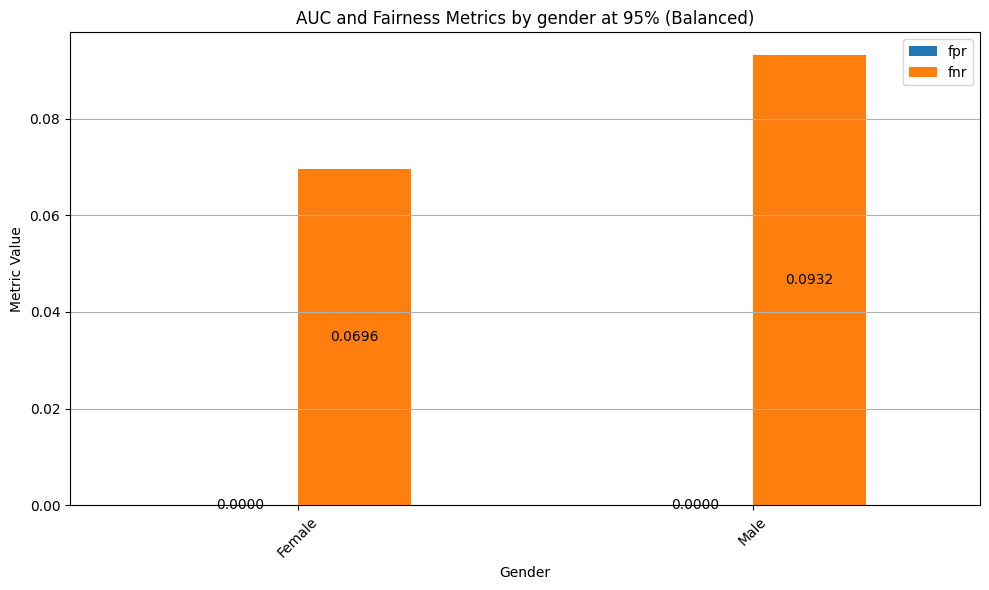

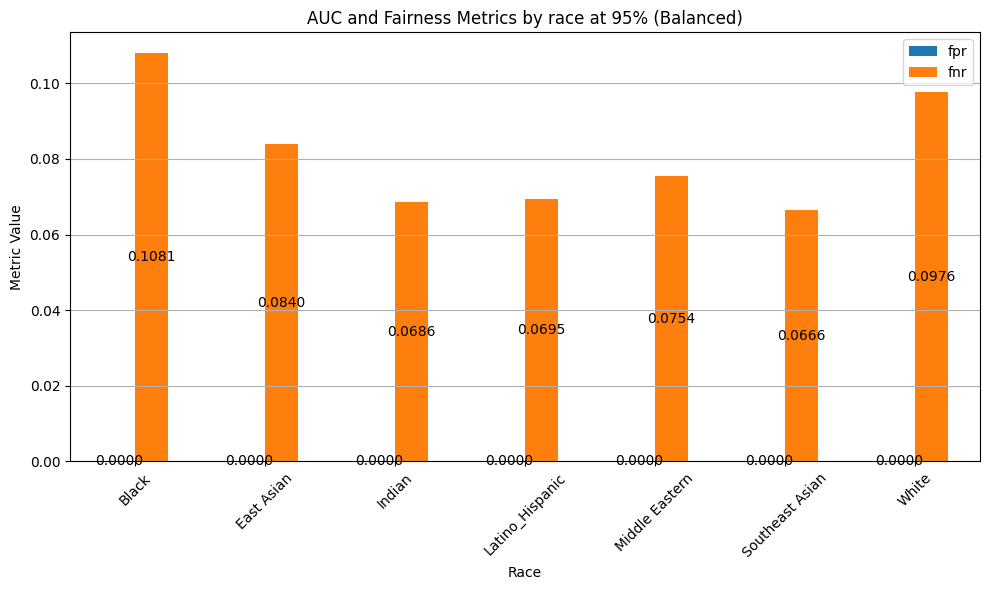

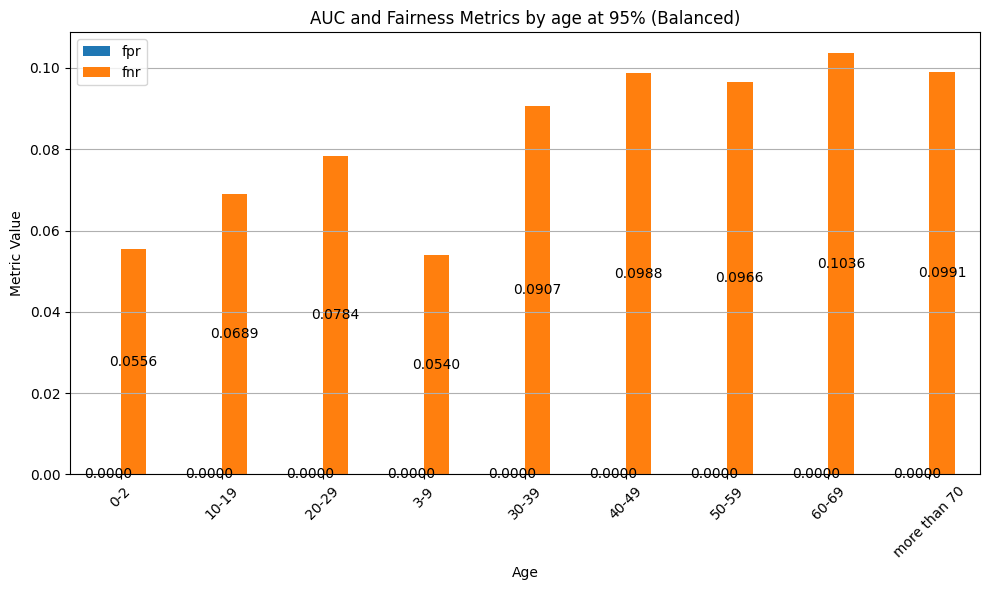

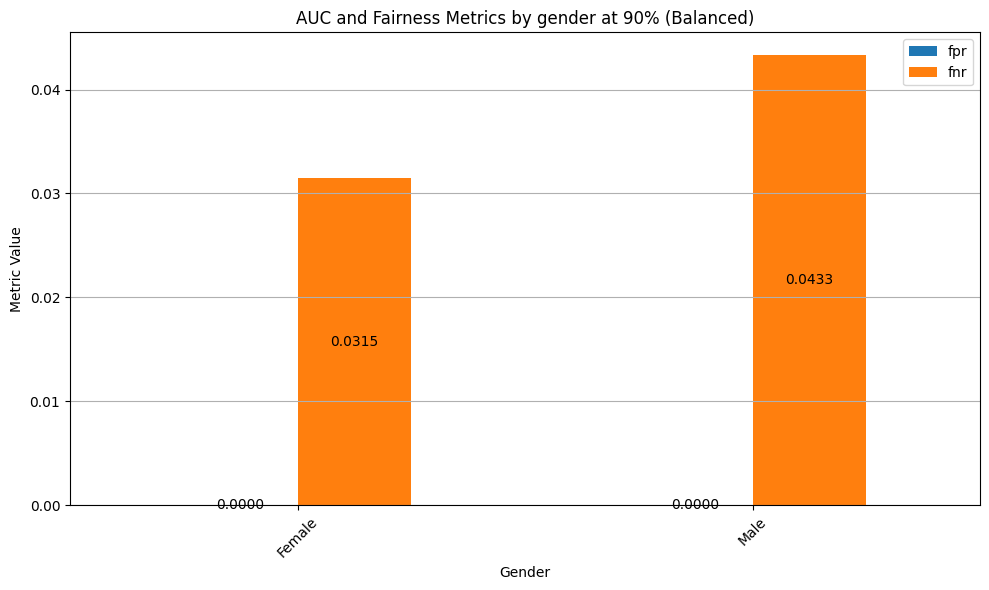

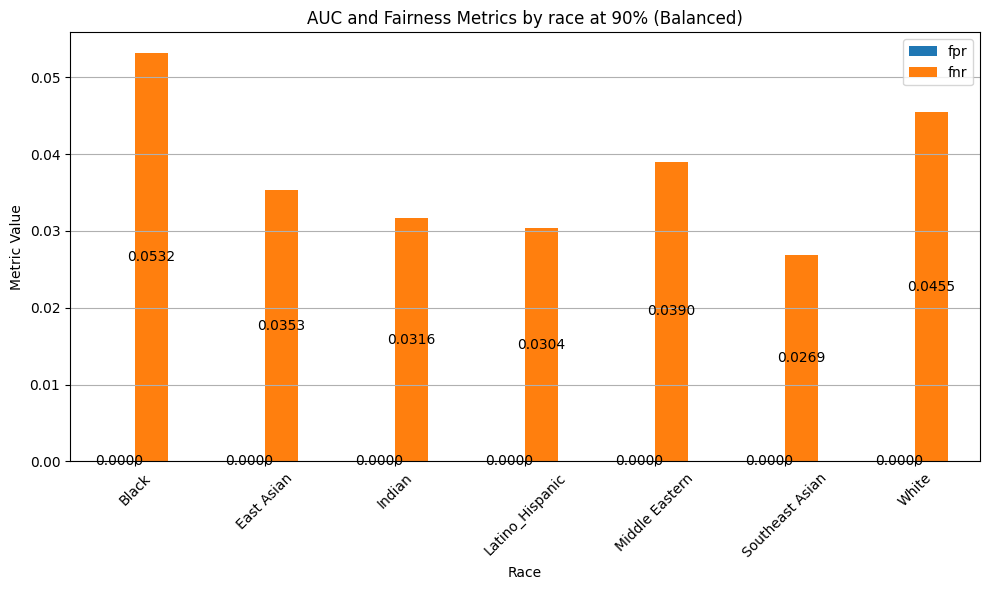

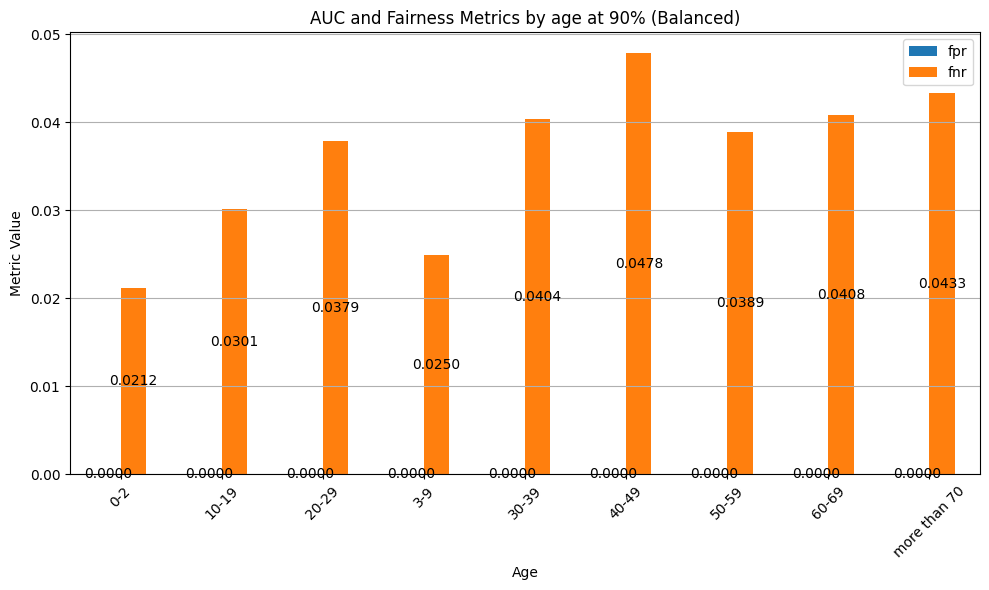

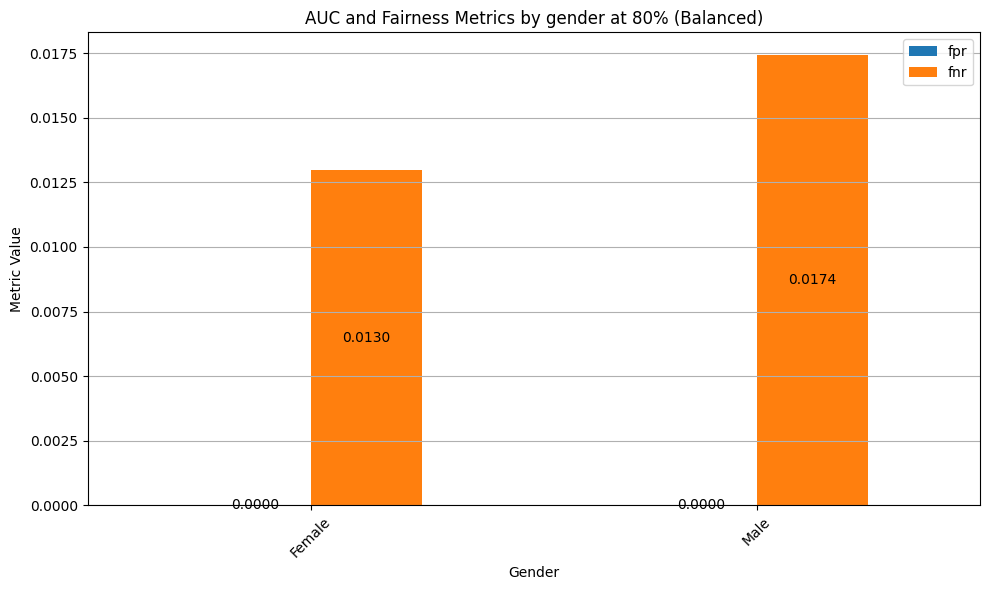

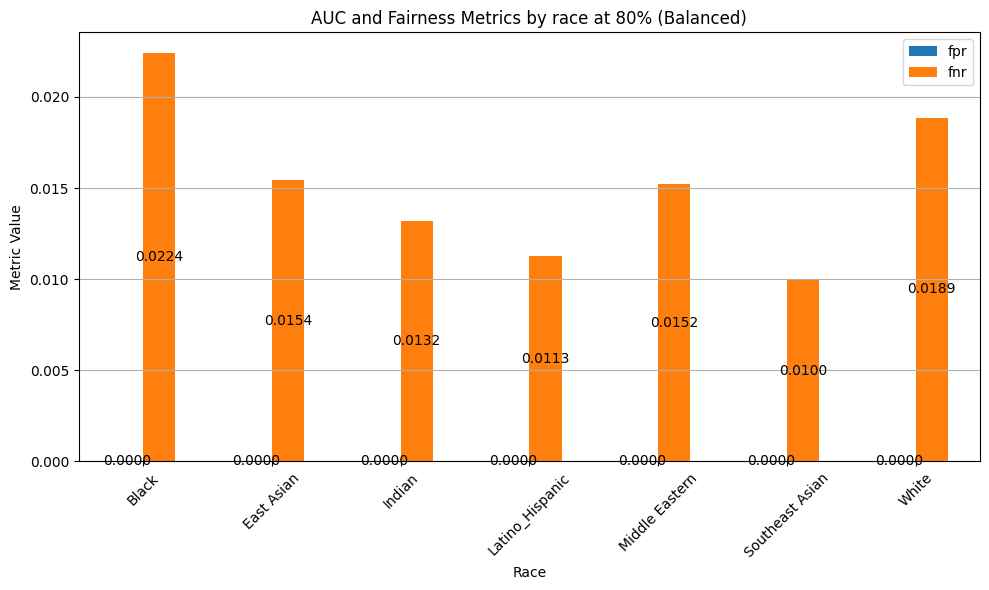

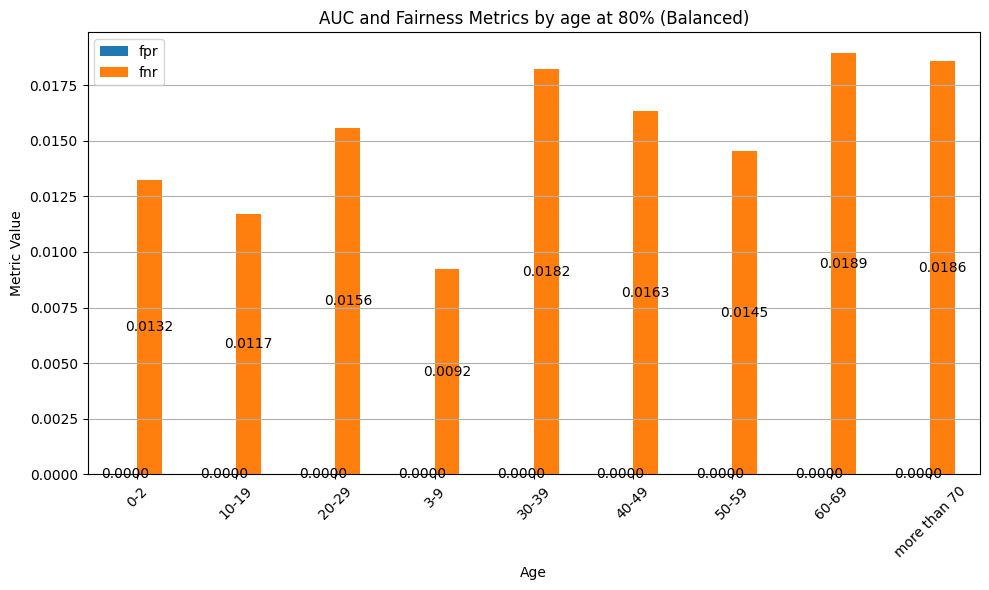

In [20]:
# Function to compute AUC and plot for each threshold
def compute_and_plot_auc_bal(df, threshold_label):
    
    # Change columns to string type for Auc Curve    
    for col in ['gender', 'race', 'age']:
        df[col] = df[col].astype(str)
    
    # Create the Group object and compute the crosstabs
    g = Group()
    xtab_bal, _ = g.get_crosstabs(df, attr_cols=['gender', 'race', 'age'])

    for group in ['gender', 'race', 'age']:
        plt.figure(figsize=(10, 6))
        xtab_group_bal = xtab_bal[xtab_bal['attribute_name'] == group].set_index('attribute_value')

        # Compute AUC for each group
        auc_dict_bal = {}
        for val, subset in df.groupby(group):
            if subset['label_value'].nunique() < 2:
                auc_dict_bal[val] = None  # Cannot compute AUC with only one class present
            else:
                auc_dict_bal[val] = roc_auc_score(subset['label_value'], subset['score'])

        # Create DataFrame from AUC dictionary
        auc_df_bal = pd.DataFrame.from_dict(auc_dict_bal, orient='index', columns=['auc'])

        # Combine FPR, FNR and AUC into one DataFrame
        group_data = xtab_group_bal[['fpr', 'fnr']].join(auc_df_bal)

        # Plot
        ax = group_data.plot(kind='bar', title=f'AUC and Fairness Metrics by {group} at {threshold_label} (Balanced)', ax=plt.gca())
        plt.ylabel('Metric Value')
        plt.xlabel(group.capitalize())
        plt.xticks(rotation=45)
        plt.grid(axis='y')
        plt.tight_layout()

        # Adding labels to each bar
        for container in ax.containers:
            ax.bar_label(container, fmt='%.4f', label_type='center')

        plt.show()

# Apply the function to each threshold DataFrame
threshold_dfs_bal = [
    (df_95_threshold_bal, "95%"),
    (df_90_threshold_bal, "90%"),
    (df_80_threshold_bal, "80%")
]

for df, label in threshold_dfs_bal:
    compute_and_plot_auc_bal(df, label)

In [21]:
def compute_and_save_auc_bal(df_bal, threshold_label):
    
    # Change columns to string type
    for col in ['gender', 'race', 'age']:
        df_bal[col] = df_bal[col].astype(str)

    # Create the Group object and compute crosstabs
    g = Group()
    xtab_bal, _ = g.get_crosstabs(df_bal, attr_cols=['gender', 'race', 'age'])

    for group in ['gender', 'race', 'age']:
        plt.figure(figsize=(10, 6))
        xtab_group_bal = xtab_bal[xtab_bal['attribute_name'] == group].set_index('attribute_value')

        # Compute AUC for each group
        auc_dict_bal = {}
        for val, subset in df_bal.groupby(group):
            if subset['label_value'].nunique() < 2:
                auc_dict_bal[val] = None  # Cannot compute AUC with only one class present
            else:
                auc_dict_bal[val] = roc_auc_score(subset['label_value'], subset['score'])

        # Create DataFrame from AUC dictionary
        auc_df_bal = pd.DataFrame.from_dict(auc_dict_bal, orient='index', columns=['auc'])

        # Combine FPR, FNR, and AUC into one DataFrame
        group_data = xtab_group_bal[['fpr', 'fnr']].join(auc_df_bal)

        # Plot
        ax = group_data.plot(kind='bar', title=f'AUC and Fairness Metrics by {group.capitalize()} at {threshold_label} (Balanced)', ax=plt.gca())
        plt.ylabel('Metric Value')
        plt.xlabel(group.capitalize())
        plt.xticks(rotation=45)
        plt.grid(axis='y')
        plt.tight_layout()

        # Adding labels to each bar
        for container in ax.containers:
            ax.bar_label(container, fmt='%.4f', label_type='center')

        # Save the plot automatically
        plt.savefig(f"auc_curve_bal_{group}_{threshold_label.replace('%', '')}.png", dpi=300)
        plt.close()  # Close after saving to avoid overlap

    print(f" Saved AUC plots for {threshold_label} (Balanced) threshold!")


threshold_dfs_bal = [
    (df_95_threshold_bal, "95%"),
    (df_90_threshold_bal, "90%"),
    (df_80_threshold_bal, "80%")
]

for df_bal, label in threshold_dfs_bal:
    compute_and_save_auc_bal(df_bal, label)

✅ Saved AUC plots for 95% (Balanced) threshold!
✅ Saved AUC plots for 90% (Balanced) threshold!
✅ Saved AUC plots for 80% (Balanced) threshold!
